<a href="https://colab.research.google.com/github/mohdyasser42/Population_Birth_Forcasting/blob/primal/Population%26Birth_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing All The Neccessary Modules**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from google.colab import drive
from scipy.stats import ttest_1samp
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [ ]:

drive.mount('/content/drive')
# read the Excel file into a pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/Major_Project/Copy of WPP2022_Demographic_Indicators_Medium.csv')

Main_df = df[['Location', 'Time','TPopulation1July','TPopulationMale1July','TPopulationFemale1July','PopSexRatio','Births','SRB','CBR']]

Main_df = Main_df[(Main_df['Time'] >= 1950) & (Main_df['Time'] <= 2022)]

#locations = set(Main_df['Location'].tolist())
times = set(Main_df['Time'].tolist())
selected_countries = ["Asia", "North America", "South America", "Europe", "Africa" ,"Oceania" , "Australia", "India", "United States of America", "Brazil", "United Kingdom","Nigeria" ]
new_df = Main_df[Main_df['Location'].isin(selected_countries)].copy()
new_df.reset_index(drop=True, inplace=True)
new_df['Location'] = new_df['Location'].str.lower()
locations = set(new_df['Location'].tolist())
new_df

Mounted at /content/drive


<ipython-input-2-6a7a4af80c46>:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Major_Project/Copy of WPP2022_Demographic_Indicators_Medium.csv')


,Location,Time,TPopulation1July,TPopulationMale1July,TPopulationFemale1July,PopSexRatio,Births,SRB,CBR
0,africa,1950,227549.258,113474.172,114075.086,99.4732,10949.117,103.9,48.102
1,africa,1951,232483.994,115915.005,116568.989,99.4390,11200.481,103.9,48.163
2,africa,1952,237586.060,118442.586,119143.474,99.4117,11448.324,103.9,48.167
3,africa,1953,242837.448,121050.757,121786.691,99.3957,11708.347,103.9,48.185
4,africa,1954,248244.771,123736.856,124507.915,99.3807,11941.297,103.9,48.075
...,...,...,...,...,...,...,...,...,...
798,australia,2018,24979.230,12390.146,12589.085,98.4198,320.272,105.9,12.876
799,australia,2019,25357.170,12578.919,12778.251,98.4401,305.145,105.8,12.090
800,australia,2020,25670.051,12738.210,12931.840,98.5027,296.417,105.8,11.576
801,australia,2021,25921.089,12867.748,13053.340,98.5782,298.496,105.7,11.542


**Deriving values of births in gender**

In [ ]:
def birthgenders(srb, births):
    denom = (srb/100)+1
    births_f = births/denom
    births_m = births-births_f
    return births_m,births_f

new_df[['BirthM', 'BirthF']] = new_df.apply(lambda row: pd.Series(birthgenders(row['SRB'], row['Births'])), axis=1)
cols = list(new_df.columns)
cols.insert(7, cols.pop(cols.index('BirthM')))
cols.insert(8, cols.pop(cols.index('BirthF')))
new_df = new_df.reindex(columns=cols)
new_df

,Location,Time,TPopulation1July,TPopulationMale1July,TPopulationFemale1July,PopSexRatio,Births,BirthM,BirthF,SRB,CBR
0,africa,1950,227549.258,113474.172,114075.086,99.4732,10949.117,5579.270507,5369.846493,103.9,48.102
1,africa,1951,232483.994,115915.005,116568.989,99.4390,11200.481,5707.356429,5493.124571,103.9,48.163
2,africa,1952,237586.060,118442.586,119143.474,99.4117,11448.324,5833.648179,5614.675821,103.9,48.167
3,africa,1953,242837.448,121050.757,121786.691,99.3957,11708.347,5966.146411,5742.200589,103.9,48.185
4,africa,1954,248244.771,123736.856,124507.915,99.3807,11941.297,6084.849231,5856.447769,103.9,48.075
...,...,...,...,...,...,...,...,...,...,...,...
798,australia,2018,24979.230,12390.146,12589.085,98.4198,320.272,164.724647,155.547353,105.9,12.876
799,australia,2019,25357.170,12578.919,12778.251,98.4401,305.145,156.872405,148.272595,105.8,12.090
800,australia,2020,25670.051,12738.210,12931.840,98.5027,296.417,152.385416,144.031584,105.8,11.576
801,australia,2021,25921.089,12867.748,13053.340,98.5782,298.496,153.383701,145.112299,105.7,11.542


In [ ]:
while True:
  country_name = input("Enter a country name: ")
  country_name = country_name.lower()
  if country_name in locations:
      break
  else:
      print("Incorrect Country name!, please try again.")
year = int(input("Enter a year: "))
print(country_name)
print(year)

Enter a country name: india
Enter a year: 2026
india
2026


In [ ]:
country_wanted = new_df[new_df['Location'] == country_name]
country_wanted

,Location,Time,TPopulation1July,TPopulationMale1July,TPopulationFemale1July,PopSexRatio,Births,BirthM,BirthF,SRB,CBR
219,india,1950,357021.100,183437.093,173584.006,105.6763,15651.496,8020.342416,7631.153584,105.1,43.838
220,india,1951,364922.360,187619.254,177303.106,105.8184,16041.888,8220.392144,7821.495856,105.1,43.957
221,india,1952,372997.188,191887.475,181109.714,105.9510,16458.330,8433.790751,8024.539249,105.1,44.117
222,india,1953,381227.705,196230.287,184997.418,106.0719,16857.475,8642.331238,8215.143762,105.2,44.203
223,india,1954,389731.406,200706.078,189025.328,106.1795,17246.702,8841.876464,8404.825536,105.2,44.238
...,...,...,...,...,...,...,...,...,...,...,...
287,india,2018,1369003.306,707149.230,661854.076,106.8437,24168.443,12571.301445,11597.141555,108.4,17.651
288,india,2019,1383112.050,714325.058,668786.993,106.8091,23583.089,12255.956915,11327.132085,108.2,17.049
289,india,2020,1396387.127,720997.448,675389.679,106.7528,23138.532,12008.886978,11129.645022,107.9,16.572
290,india,2021,1407563.842,726503.429,681060.412,106.6724,23113.533,11985.207049,11128.325951,107.7,16.419


In [ ]:
country_wanted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 219 to 291
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Location                73 non-null     object 
 1   Time                    73 non-null     int64  
 2   TPopulation1July        73 non-null     float64
 3   TPopulationMale1July    73 non-null     float64
 4   TPopulationFemale1July  73 non-null     float64
 5   PopSexRatio             73 non-null     float64
 6   Births                  73 non-null     float64
 7   BirthM                  73 non-null     float64
 8   BirthF                  73 non-null     float64
 9   SRB                     73 non-null     float64
 10  CBR                     73 non-null     float64
dtypes: float64(9), int64(1), object(1)
memory usage: 6.8+ KB


In [ ]:
country_wanted.shape

(73, 11)

In [ ]:
x_cols_drop = ['Location','TPopulation1July','TPopulationMale1July','TPopulationFemale1July','PopSexRatio','Births','BirthM','BirthF','SRB','CBR']
y_cols_drop = ['Location','Time','TPopulation1July','PopSexRatio','Births','SRB','CBR']

In [ ]:
x = country_wanted.drop(columns=x_cols_drop)
y = country_wanted.drop(columns=y_cols_drop)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
print("X_train:",x_train.shape)
print("X_test:",x_test.shape)
print("Y_train:",y_train.shape)
print("Y_test:",y_test.shape)

X_train: (58, 1)
X_test: (15, 1)
Y_train: (58, 4)
Y_test: (15, 4)


In [ ]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
scaler.mean_

array([1987.53448276])

In [ ]:
x_train_scaled = pd.DataFrame(x_train_scaled, columns = x_train.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns = x_test.columns)

In [ ]:
x_train_scaled.describe()

,Time
count,5.800000e+01
mean,-4.058057e-16
std,1.008734e+00
min,-1.823253e+00
25%,-8.126768e-01
50%,4.818412e-02
75%,8.092351e-01
max,1.670096e+00


In [ ]:
x_test_scaled.describe()

,Time
count,15.000000
mean,-0.372681
std,1.226698
min,-1.873158
25%,-1.399060
50%,-0.475818
75%,0.622091
max,1.720001


#RUNNING ALL THE MODELS

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor()
}

In [ ]:
model_list = []
r2_list =[]

In [ ]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [ ]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train_scaled, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(x_train_scaled)
    y_test_pred = model.predict(x_test_scaled)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 11256.8795
- Mean Absolute Error: 7146.7506
- R2 Score: 0.7439
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 14697.4607
- Mean Absolute Error: 9287.3949
- R2 Score: 0.7509


Lasso
Model performance for Training set
- Root Mean Squared Error: 11256.8795
- Mean Absolute Error: 7146.9211
- R2 Score: 0.7439
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 14697.0963
- Mean Absolute Error: 9287.5180
- R2 Score: 0.7508


Ridge
Model performance for Training set
- Root Mean Squared Error: 11418.4916
- Mean Absolute Error: 7551.9666
- R2 Score: 0.7436
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 13847.0851
- Mean Absolute Error: 9072.6867
- R2 Score: 0.7497


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 3092.1747
- Mean Absolute Error: 1464

In [ ]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
5,Random Forest Regressor,0.997047
6,XGBRegressor,0.994996
4,Decision Tree,0.994658
3,K-Neighbors Regressor,0.993488
0,Linear Regression,0.750897
1,Lasso,0.750812
2,Ridge,0.749740


# **Pridicting The Attributes Using Random Forest Regressor**

In [ ]:

rfr_model = RandomForestRegressor()
model = rfr_model.fit(x_train_scaled, y_train)
y_pred = rfr_model.predict(x_test_scaled)

In [ ]:
print(y_pred)

[[196080.11746    184879.84199      8614.84421681   8191.60700319]
 [666456.95934    622962.08989     13279.04535479  12159.79078521]
 [275049.05895    257059.55446     10990.38153869  10432.15089131]
 [190211.13532    179626.79909      8337.59618795   7932.29534205]
 [347421.74433    323413.60857     12629.95851412  11869.25477588]
 [722660.5672     677181.22431     12056.15800611  11178.92573389]
 [230036.95565    215742.26446      9730.12160486   9252.04513514]
 [389761.90373    363197.56964     13670.89953789  12800.46773211]
 [240994.1912     225779.6459      10072.58537407   9574.70092593]
 [603919.17178    563248.09546     14304.84781804  13085.11955196]
 [682822.05352    638626.85087     12928.65450473  11866.28330527]
 [365163.86251    339991.38989     13116.53757505  12291.49642495]
 [220430.52667    206955.97861      9437.26235781   8978.08113219]
 [495776.65206    463371.08405     14701.04199371  13536.84845629]
 [209913.10277    197383.12017      9127.61026232   8679.00949

In [ ]:
Accuracy=r2_score(y_test,y_pred)*100
print(" Accuracy of the model is %.2f" %Accuracy)

 Accuracy of the model is 99.75


In [ ]:
y_test.iloc[:,0]

223    200706.078
282    667322.884
237    275736.482
219    183437.093
247    345069.608
291    731180.498
229    230135.579
253    394865.497
231    241125.862
274    597477.666
284    683543.212
250    369149.846
228    224885.438
264    498432.464
224    205350.073
Name: TPopulationMale1July, dtype: float64

In [ ]:
pred_df=pd.DataFrame({'Actual Male Pop Value': y_test.iloc[:,0],
                        'Predicted Male Pop Value': y_pred[:,0],
                        'Difference in Male Pop': y_test.iloc[:,0] - y_pred[:,0],
                        'Actual Female Pop Value': y_test.iloc[:,1],
                        'Predicted Female Pop Value': y_pred[:,1],
                        'Difference in Female Pop': y_test.iloc[:,1] - y_pred[:,1],
                        'Actual Male Birth Value': y_test.iloc[:,2],
                        'Predicted Male Birth Value': y_pred[:,2],
                        'Difference in Male Birth': y_test.iloc[:,2] - y_pred[:,2],
                        'Actual Female Birth Value': y_test.iloc[:,3],
                        'Predicted Female Birth Value': y_pred[:,3],
                        'Difference in Female Birth': y_test.iloc[:,3] - y_pred[:,3]
                        })
pred_df


,Actual Male Pop Value,Predicted Male Pop Value,Difference in Male Pop,Actual Female Pop Value,Predicted Female Pop Value,Difference in Female Pop,Actual Male Birth Value,Predicted Male Birth Value,Difference in Male Birth,Actual Female Birth Value,Predicted Female Birth Value,Difference in Female Birth
223,200706.078,196080.11746,4625.96054,189025.328,184879.84199,4145.48601,8841.876464,8614.844217,227.032247,8404.825536,8191.607003,213.218533
282,667322.884,666456.95934,865.92466,623809.180,622962.08989,847.09011,13429.853638,13279.045355,150.808283,12309.673362,12159.790785,149.882577
237,275736.482,275049.05895,687.42305,257695.426,257059.55446,635.87154,11004.019260,10990.381539,13.637721,10450.160740,10432.150891,18.009849
219,183437.093,190211.13532,-6774.04232,173584.006,179626.79909,-6042.79309,8020.342416,8337.596188,-317.253772,7631.153584,7932.295342,-301.141758
247,345069.608,347421.74433,-2352.13633,321198.151,323413.60857,-2215.45757,12491.628345,12629.958514,-138.330169,11751.296655,11869.254776,-117.958121
291,731180.498,722660.56720,8519.93080,685992.675,677181.22431,8811.45069,11944.688687,12056.158006,-111.469319,11111.338313,11178.925734,-67.587421
229,230135.579,230036.95565,98.62335,215819.000,215742.26446,76.73554,9719.012737,9730.121605,-11.108868,9238.605263,9252.045135,-13.439872
253,394865.497,389761.90373,5103.59327,368029.660,363197.56964,4832.09036,13835.179870,13670.899538,164.280332,12942.170130,12800.467732,141.702398
231,241125.862,240994.19120,131.67080,225898.332,225779.64590,118.68610,10080.410624,10072.585374,7.825250,9582.139376,9574.700926,7.438450
274,597477.666,603919.17178,-6441.50578,557161.048,563248.09546,-6087.04746,14443.385581,14304.847818,138.537763,13202.363419,13085.119552,117.243867


# **Predicting The Attributes**

In [ ]:
x_pred = [[year]]

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    predict_test = model.predict(x_pred)
print(predict_test)

[[722660.5672     677181.22431     12056.15800611  11178.92573389]]


In [ ]:
pred_TPop = predict_test[:,0] + predict_test[:,1]
pred_PopSR = (predict_test[:,0] / predict_test[:,1])*100
pred_Tbirths = predict_test[:,2] + predict_test[:,3]
pred_SRB = (predict_test[:,2] / predict_test[:,3])*100
pred_CBR = (pred_Tbirths / pred_TPop)*1000

Final_Pridicted_Values = [pred_TPop]
print(Final_Pridicted_Values)

print('Pridicted Male Population: ',predict_test[:,0])
print('Pridicted Female Population: ',predict_test[:,1])
print('Pridicted Total Population: ',pred_TPop)
print('Pridicted Gender Ratio: ',pred_PopSR)
print('Pridicted Male Births: ',predict_test[:,2])
print('Pridicted Female Births: ',predict_test[:,3])
print('Pridicted Total Births: ',pred_Tbirths)
print('Pridicted Gender Ratio of Births: ',pred_SRB)
print('Pridicted Birth Rate: ',pred_CBR)

[array([1399841.79151])]
Pridicted Male Population:  [722660.5672]
Pridicted Female Population:  [677181.22431]
Pridicted Total Population:  [1399841.79151]
Pridicted Gender Ratio:  [106.71597812]
Pridicted Male Births:  [12056.15800611]
Pridicted Female Births:  [11178.92573389]
Pridicted Total Births:  [23235.08374]
Pridicted Gender Ratio of Births:  [107.84719653]
Pridicted Birth Rate:  [16.5983641]


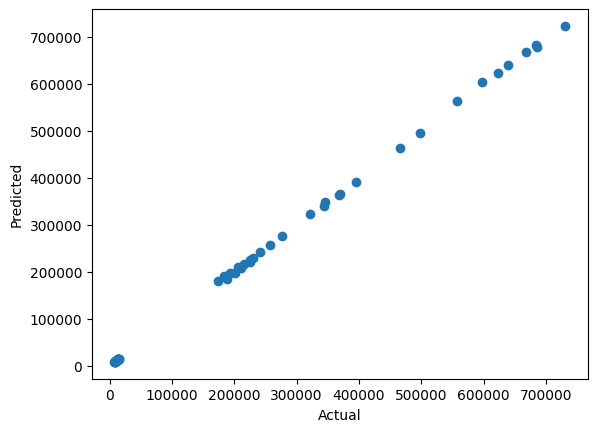

In [ ]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

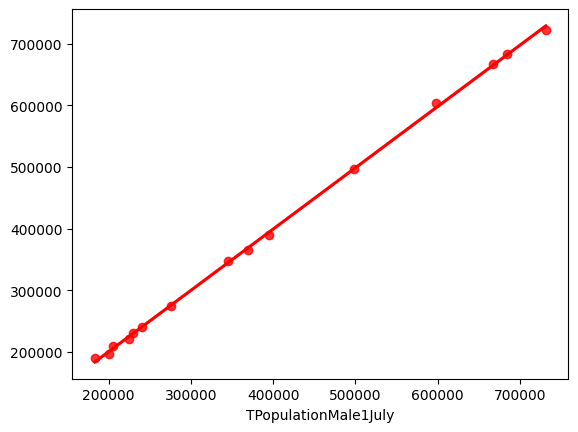

In [ ]:
sns.regplot(x=y_test.iloc[:,0],y=y_pred[:,0],ci=None,color ='red');

# **Time Series Forcasting Using Moving Average Model**

In [ ]:
ma = country_wanted['CBR'].rolling(window=5).mean()

# View the results
print(ma)

219        NaN
220        NaN
221        NaN
222        NaN
223    44.0706
        ...   
287    18.3780
288    17.9780
289    17.5394
290    17.1204
291    16.7916
Name: CBR, Length: 73, dtype: float64


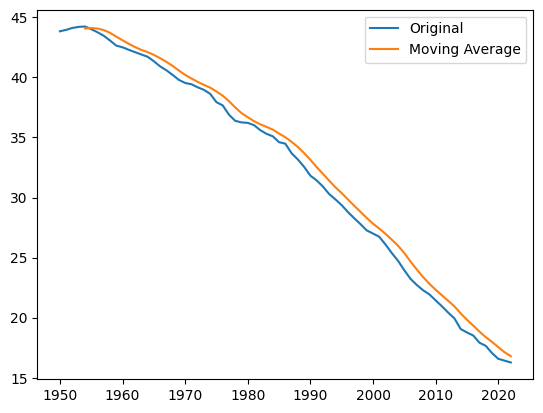

In [ ]:
fig, ax = plt.subplots()
ax.plot(country_wanted['Time'], country_wanted['CBR'], label='Original')
ax.plot(country_wanted['Time'], ma, label='Moving Average')
ax.legend()

# Show the plot
plt.show()

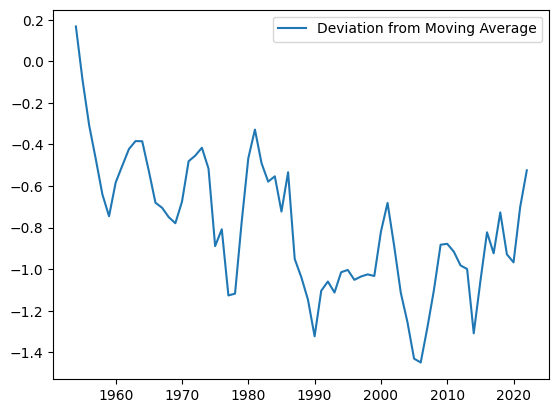

In [ ]:
# Calculate the deviation from the moving average
deviation = country_wanted['CBR'] - ma

# Plot the deviation from the moving average
fig, ax = plt.subplots()
ax.plot(country_wanted['Time'], deviation, label='Deviation from Moving Average')
ax.legend()

# Show the plot
plt.show()

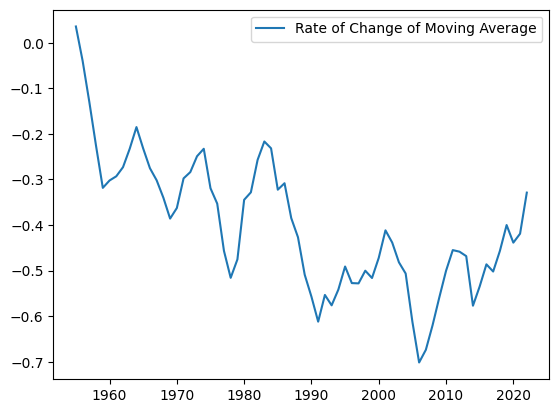

In [ ]:
# Calculate the rate of change of the moving average
ma_diff = ma.diff()

# Plot the rate of change of the moving average
fig, ax = plt.subplots()
ax.plot(country_wanted['Time'], ma_diff, label='Rate of Change of Moving Average')
ax.legend()

# Show the plot
plt.show()


In [ ]:

# Perform a one-sample t-test on the moving average
null_hypothesis = 10  # Example null hypothesis value
t_stat, p_value = ttest_1samp(ma, null_hypothesis)

if p_value < 0.05:
    print('The moving average is significantly different from the null hypothesis')
else:
    print('The moving average is not significantly different from the null hypothesis')


The moving average is not significantly different from the null hypothesis
